347


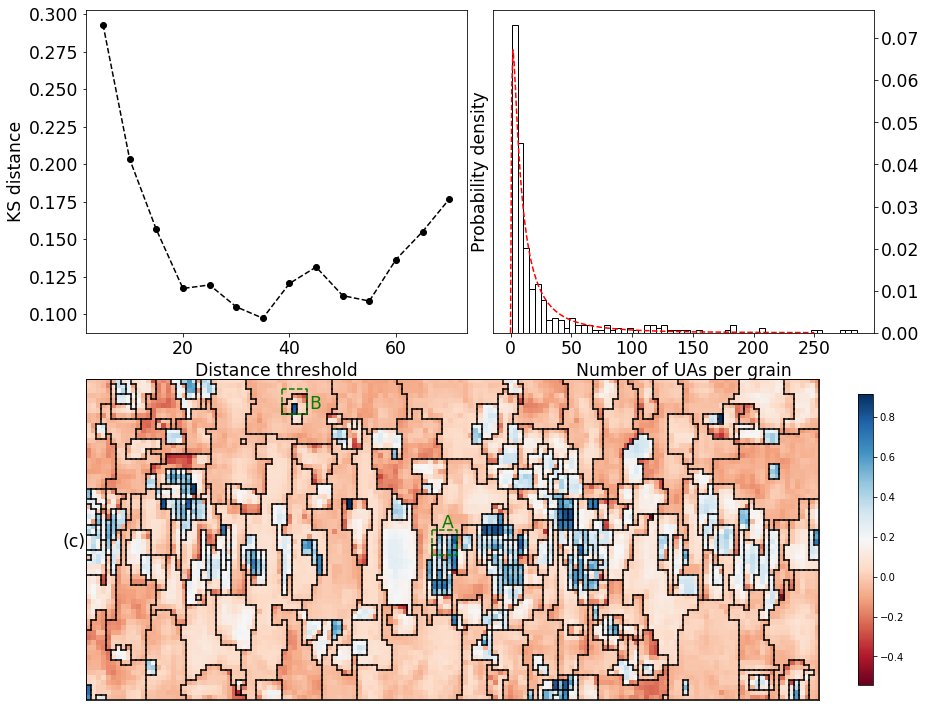

In [20]:
import sys
sys.path.append("..")
import numpy as np
import matplotlib.pyplot as plt
#import matplotlib.gridspec as gridspec

from scipy import fft
from scipy import stats


#import lauetools.LaueTools.IOimagefile as IOimage

#from libtiff import TIFF

from sklearn.decomposition import PCA


from sklearn import cluster
from sklearn.feature_extraction.image import grid_to_graph

from sklearn import metrics

def draw(ax,labels):
    nx,ny=labels.shape
    ax.plot(np.array([0,nx,nx,0,0])-0.5,np.array([0,0,ny,ny,0])-0.5,'k')
    ax.set_aspect('equal')
    for i in range(nx):
        for j in range(ny-1):
            if labels[i,j]!=labels[i,j+1]:
                ax.plot(np.array([i,i+1])-0.5,np.array([j+1,j+1])-0.5,'k')
    for i in range(nx-1):
        for j in range(ny):
            if labels[i,j]!=labels[i+1,j]:
                ax.plot(np.array([i+1,i+1])-0.5,np.array([j,j+1])-0.5,'k')
    return None

n_pca=1024
nx,ny=64,146

#ns_clusters_=[x for x in range(50,200,25)]+[x for x in range(200,400,50)]+[x for x in range(400,800,100)]+[x for x in range(800,2000,200)]+[x for x in range(2000,4000,400)]+[x for x in range(4000,8000,800)]+[8000,9300]#np.arange(100,9400,100)
def KS(labels):
    n=np.unique(labels)
    counts=[]
    for i in range(n.shape[0]):
        counts.append(np.where(labels==n[i])[0].shape[0])
    #print(counts)
    counts=np.log(np.array(counts))
    mu, sigma = counts.mean(), counts.std()
    counts=(counts-mu)/sigma
    return stats.kstest(counts,stats.norm.cdf)

ks,sils,cals,davs=[],[],[],[]
thres=range(5,75,5)
for thre in thres:
    labels,sil,cal,dav=np.load('res_%i_%i.npy'%(n_pca,thre),allow_pickle=True)
    sils.append(sil)
    cals.append(cal)
    davs.append(dav)
    ks.append(KS(np.array(labels))[0])

#X=np.load('spatial_X.npy')#[:nx,60:60+ny,:]
opti_thre=thres[np.array(ks).argmin()]
FA_spatial=np.load('full_spatial_features.npy')

ratio=ny/nx


fig = plt.figure(constrained_layout=False,figsize=(12,12))
gs = fig.add_gridspec(nrows=2, ncols=2, left=0, right=0.4*ratio,bottom=0,top=0.8, wspace=0.07,hspace=0.14)#,sharex=True)

ax1 = fig.add_subplot(gs[0,0])

t1,=ax1.plot(thres,ks,'ko--')

ax1.tick_params(axis='x', labelsize= "xx-large")
ax1.tick_params(axis='y', labelsize= "xx-large")

"""
axins = ax1.inset_axes([0.1, 0.53, 0.35, 0.45])
axins.plot(ns_clusters_,ks,'ko--')
# sub region of the original image
x1, x2, y1, y2 = ns_clusters_[ks.argmin()-5],ns_clusters_[ks.argmin()+4],0.05,0.1
axins.set_xlim(x1, x2)
axins.set_ylim(y1, y2)

axins.tick_params(axis='x', labelsize= "x-large")
axins.tick_params(axis='y', labelsize= "x-large")

ax1.indicate_inset_zoom(axins,alpha=1)
"""
ax1.set_xlabel('Distance threshold',size='xx-large')
ax1.set_ylabel('KS distance',size='xx-large')


#t2,=plt.plot(ns_clusters_,np.load('ks256.npy'),'ko--')
#t3,=plt.plot(ns_clusters_,np.load('ks1024.npy'),'k*--')
#t4,=plt.plot(ns_clusters_,np.load('ks4096.npy'),'k+--')

ax2 = fig.add_subplot(gs[1,:])
pca = PCA(n_components=n_pca, svd_solver='full')
pca_features=pca.fit_transform(FA_spatial)#components_
connectivity = grid_to_graph(n_x=nx, n_y=ny)
ward = cluster.AgglomerativeClustering(n_clusters=None, connectivity=connectivity, linkage='ward', compute_full_tree=True,distance_threshold=opti_thre).fit(pca_features)
labels = ward.labels_
#ax2.imshow(labels.reshape((nx,ny)))
#draw(ax2,np.flip(labels.reshape((nx,ny)).T,1))
draw(ax2,labels.reshape((nx,ny)).T)

ax2.set_yticks([])
ax2.set_xticks([])

#ax2.axis('off')

sil=metrics.silhouette_samples(pca_features,labels)

np.save('opti_labels',labels)
np.save('opti_sil',sil)

im=ax2.imshow(sil.reshape((nx,ny)),cmap='RdBu')
cbar = fig.colorbar(im, shrink=0.9,ax=ax2,anchor=(0,0),fraction=0.02)#,orientation='horizontal')

x1, x2, y1, y2 = 69,74,30,35
ax2.plot(np.array([x1,x1,x2,x2,x1])-0.5,np.array([y1,y2,y2,y1,y1])-0.5,'g--')
ax2.text((x1+x2)/2,y1,"A",size='xx-large',verticalalignment='bottom',horizontalalignment='center',color='g')

x1, x2, y1, y2 = 39,44,2,7
ax2.plot(np.array([x1,x1,x2,x2,x1])-0.5,np.array([y1,y2,y2,y1,y1])-0.5,'g--')
ax2.text(x2,(y1+y2)/2,"B",size='xx-large',verticalalignment='center',horizontalalignment='left',color='g')

#ax2.set_ylabel("(c)",size='xx-large')#,orientation='horizontal')
ax2.text(-0.5,32.,"(c)",size='xx-large',verticalalignment='center',horizontalalignment='right',color='k')
#ax2.set_xlabel('(c)',size='xx-large')


ax3 = fig.add_subplot(gs[0,1])

ax3.yaxis.tick_right()
n=np.unique(labels)
print(n.shape[0])
counts=[]
for i in range(n.shape[0]):
    counts.append(np.where(labels==n[i])[0].shape[0])
counts=np.array(counts)

ax3.hist(counts,bins=60,color='white',edgecolor='black',density=True)

ax3.tick_params(axis='x', labelsize= "xx-large")
ax3.tick_params(axis='y', labelsize= "xx-large")

x=np.linspace(0,250,250)
logcounts=np.log(counts)
y=stats.lognorm.pdf(x,s=logcounts.std(),scale=np.exp(logcounts.mean()))#*9344
ax3.plot(x,y,'r--')
ax3.set_xlabel('Number of UAs per grain',size='xx-large')
ax3.set_ylabel('Probability density',size='xx-large')

"""
ax4 = fig.add_subplot(gs[2,:])

ax4.set_aspect('equal')
sil=metrics.silhouette_samples(pca_features,labels)

im=ax4.imshow(sil.reshape((nx,ny)),cmap='RdBu')
#cbar = fig.colorbar(im, shrink=1.2,ax=ax4,pad=0.01,anchor=(0,0),fraction=0.02)#,orientation='horizontal')
cbar = fig.colorbar(im, shrink=0.7,ax=ax4,pad=0.01,anchor=(0,0),orientation='horizontal')
#cbar = fig.colorbar(im, shrink=0.8,ax=ax4)
cbar.ax.tick_params(labelsize='xx-large')

#ticklabs = cbar.ax.get_yticklabels()
#cbar.ax.set_yticklabels(ticklabs, fontsize=20)
#ticklabs.set_fontsize(20)

ax4.axis('off')
"""
#plt.legend([t1,t2,t3,t4],["$N_{\mathrm{PCA}}=64$","$N_{\mathrm{PCA}}=256$","$N_{\mathrm{PCA}}=1024$","$N_{\mathrm{PCA}}=4096$"],fontsize='xx-large',ncol=2,loc=(-0.2,1.01))
#ax1.text("(a)")

plt.savefig('v2_fig10.tif',format='tif',bbox_inches ='tight')